## Training of the valuation of CAT bonds with Lognormal distributed losses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam


import itertools
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

Read the data

In [3]:
# Load your dataset (replace with your actual file path)
df = pd.read_csv("CAT_price_log.csv")

print(df.head())
print(df.shape)

      c         r  kappa  theta  sigma     lambda             D   N         T  \
0  0.05  0.003739    0.2   0.03   0.02  33.657519  1.123166e+10   6  1.754300   
1  0.05  0.068378    0.2   0.03   0.02  32.508333  1.165157e+10   3  1.077251   
2  0.05  0.072130    0.2   0.03   0.02  31.220017  8.743499e+09  10  0.825559   
3  0.05  0.070647    0.2   0.03   0.02  38.028365  1.040211e+10   2  0.705678   
4  0.05  0.045657    0.2   0.03   0.02  35.865139  7.958977e+09   0  0.723634   

         Price  
0  1087.077328  
1  1073.187665  
2  1423.204930  
3  1048.772705  
4   956.936061  
(600000, 10)


In [4]:
# Define your features (X) and labels (y)
# Replace 'feature_columns' and 'target_column' with actual column names
X = df[['r','lambda', 'D', 'N', 'T']]
y = df['Price'] / 1000

print(X.head())
print(y.head())

          r     lambda             D   N         T
0  0.003739  33.657519  1.123166e+10   6  1.754300
1  0.068378  32.508333  1.165157e+10   3  1.077251
2  0.072130  31.220017  8.743499e+09  10  0.825559
3  0.070647  38.028365  1.040211e+10   2  0.705678
4  0.045657  35.865139  7.958977e+09   0  0.723634
0    1.087077
1    1.073188
2    1.423205
3    1.048773
4    0.956936
Name: Price, dtype: float64


Prepare the data

## Model-Building Function
Create a function that builds a Keras model based on input parameters. This function allows flexibility in specifying the number of layers, neurons, activation functions, regularization, etc.

In [8]:
def build_model(input_dim,
                nr_neurons,
                reg_param=0.00,
                activation='relu',
                use_batch_norm=True,
                dropout_rate=0.0,
                learning_rate=0.005):
    """
    Builds a customizable neural network model for regression tasks.

    Parameters:
    - input_dim (int): Number of input features.
    - nr_neurons (list): List defining the number of neurons in each hidden layer.
                            Example: [64, 32] for 2 layers with 64 and 32 neurons.
    - reg_param (float): L2 regularization parameter.
    - activation (str): Activation function for hidden layers.
    - use_batch_norm (bool): Whether to use Batch Normalization.
    - dropout_rate (float): Dropout rate for regularization.

    Returns:
    - model (keras.Model): Compiled Keras model.
    """
    model = models.Sequential()

    # Input layer (first hidden layer)
    model.add(layers.Dense(nr_neurons[0],
                           kernel_regularizer=regularizers.l2(reg_param),
                           activation=activation,
                           input_shape=(input_dim,)))

    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if dropout_rate > 0.0:
        model.add(layers.Dropout(dropout_rate))

    # Add remaining hidden layers
    for neurons in nr_neurons[1:]:
        model.add(layers.Dense(neurons,
                               kernel_regularizer=regularizers.l2(reg_param),
                               activation=activation))
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1))  # Single output for regression

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae', 'mse'])

    return model

### Early Stopping and Model Checkpointing:
Incorporate callbacks to prevent overfitting and save the best model during training.

In [14]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
#checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

## Define Configurations to Test
Specify the different configurations you want to test. For example, varying the number of neurons, activation functions, regularization parameters, etc.

In [10]:
# Define different configurations
layer_configs = [
#    [64, 32],                  # 2 layers: 64 neurons -> 32 neurons
#    [128, 64, 32],             # 3 layers: 128 neurons -> 64 neurons -> 32 neurons
    [256, 128, 64, 32],        # 4 layers: 256 -> 128 -> 64 -> 32 neurons
    [256, 256, 128, 64, 32],   # 5 layers: 256 -> 256 -> 128 -> 64 -> 32 neurons
]

activations = ['relu','tanh']
reg_params = [1e-04]
dropout_rates = [0.1]
use_batch_norm_options = [True]
learning_rates = [1e-04, 5e-05, 1e-05]

# Create all possible combinations
configurations = list(itertools.product(layer_configs, activations, reg_params, dropout_rates, use_batch_norm_options, learning_rates))

print(f"Total configurations to test: {len(configurations)}")

Total configurations to test: 12


## Implement K-Fold Cross-Validation
Use K-Fold Cross-Validation to evaluate each configuration robustly.

In [16]:
# Parameters
EPOCHS = 500
BATCH_SIZE = 512
NR_FOLDS = 5  # Number of folds for cross-validation

# Initialize K-Fold
kf = KFold(n_splits=NR_FOLDS, shuffle=True, random_state=42)

# Prepare a DataFrame to store results
results = []

# Iterate over each configuration
for idx, (layer_config, activation, reg_param, dropout_rate, use_batch_norm, learning_rate) in enumerate(configurations):
    print(f"\n--- Configuration {idx+1}/{len(configurations)} ---")
    print(f"Layers: {layer_config}, Activation: {activation}, L2: {reg_param}, Dropout: {dropout_rate}, BatchNorm: {use_batch_norm}, LearningRate: {learning_rate}")

    # Lists to store metrics for each fold
    fold_losses = []
    fold_maes = []
    fold_mses = []

    # Iterate over each fold
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"  Fold {fold+1}/{NR_FOLDS}")

        # Split data into training and validation for this fold
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Scale the data
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        # Build the model
        model = build_model(input_dim=X_train_fold_scaled.shape[1],
                            nr_neurons=layer_config,
                            reg_param=reg_param,
                            activation=activation,
                            use_batch_norm=use_batch_norm,
                            dropout_rate=dropout_rate,
                            learning_rate=learning_rate)
        
#         model.summary()

        # Train the model
        history = model.fit(X_train_fold_scaled, y_train_fold,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_val_fold_scaled, y_val_fold),
                            callbacks=[early_stop],
                            verbose=0)  # Set verbose=1 for detailed output

        # Evaluate the model
        val_loss, val_mae, val_mse = model.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)
        print(f"    Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}")

        # Append metrics
        fold_losses.append(val_loss)
        fold_maes.append(val_mae)
        fold_mses.append(val_mse)

    # Calculate average metrics across folds
    avg_loss = np.mean(fold_losses)
    avg_mae = np.mean(fold_maes)
    avg_mse = np.mean(fold_mses)

    print(f"  Average Loss: {avg_loss:.4f}, Average MAE: {avg_mae:.4f}, Average MSE: {avg_mse:.4f}")

    # Store the results
    results.append({
        'Layers': layer_config,
        'Activation': activation,
        'L2_Regularization': reg_param,
        'Dropout_Rate': dropout_rate,
        'Batch_Normalization': use_batch_norm,
        'Learning_Rate': learning_rate,
        'Average_Loss': avg_loss,
        'Average_MAE': avg_mae,
        'Average_MSE': avg_mse
    })

    # Optional: Clear the Keras session to free memory after each configuration
    keras.backend.clear_session()


--- Configuration 1/12 ---
Layers: [256, 128, 64, 32], Activation: relu, L2: 0.0001, Dropout: 0.1, BatchNorm: True, LearningRate: 0.0001
  Fold 1/5
    Loss: 0.0001, MAE: 0.0045, MSE: 0.0000
  Fold 2/5
    Loss: 0.0001, MAE: 0.0046, MSE: 0.0000
  Fold 3/5
    Loss: 0.0001, MAE: 0.0045, MSE: 0.0000
  Fold 4/5
    Loss: 0.0001, MAE: 0.0044, MSE: 0.0000
  Fold 5/5
    Loss: 0.0001, MAE: 0.0053, MSE: 0.0001
  Average Loss: 0.0001, Average MAE: 0.0046, Average MSE: 0.0000

--- Configuration 2/12 ---
Layers: [256, 128, 64, 32], Activation: relu, L2: 0.0001, Dropout: 0.1, BatchNorm: True, LearningRate: 5e-05
  Fold 1/5
    Loss: 0.0001, MAE: 0.0038, MSE: 0.0000
  Fold 2/5
    Loss: 0.0001, MAE: 0.0041, MSE: 0.0000
  Fold 3/5
    Loss: 0.0001, MAE: 0.0041, MSE: 0.0000
  Fold 4/5
    Loss: 0.0001, MAE: 0.0042, MSE: 0.0000
  Fold 5/5
    Loss: 0.0001, MAE: 0.0043, MSE: 0.0000
  Average Loss: 0.0001, Average MAE: 0.0041, Average MSE: 0.0000

--- Configuration 3/12 ---
Layers: [256, 128, 64, 32],

## Analyze and Visualize Results
After testing all configurations, convert the results into a pandas DataFrame for easier analysis and visualization.

In [17]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("\n--- Cross-Validation Results ---")
print(results_df.sort_values(by='Average_MSE').reset_index(drop=True))

# Save results to CSV for future reference
results_df.to_csv('NN_configurations_results_lognormal.csv', index=False)


--- Cross-Validation Results ---
                     Layers Activation  L2_Regularization  Dropout_Rate  \
0        [256, 128, 64, 32]       relu             0.0001           0.1   
1   [256, 256, 128, 64, 32]       relu             0.0001           0.1   
2        [256, 128, 64, 32]       relu             0.0001           0.1   
3   [256, 256, 128, 64, 32]       relu             0.0001           0.1   
4        [256, 128, 64, 32]       tanh             0.0001           0.1   
5        [256, 128, 64, 32]       relu             0.0001           0.1   
6   [256, 256, 128, 64, 32]       tanh             0.0001           0.1   
7        [256, 128, 64, 32]       tanh             0.0001           0.1   
8   [256, 256, 128, 64, 32]       relu             0.0001           0.1   
9   [256, 256, 128, 64, 32]       tanh             0.0001           0.1   
10       [256, 128, 64, 32]       tanh             0.0001           0.1   
11  [256, 256, 128, 64, 32]       tanh             0.0001         

### Visualizing Performance Across Configurations
You can create plots to visualize how different parameters impact performance.

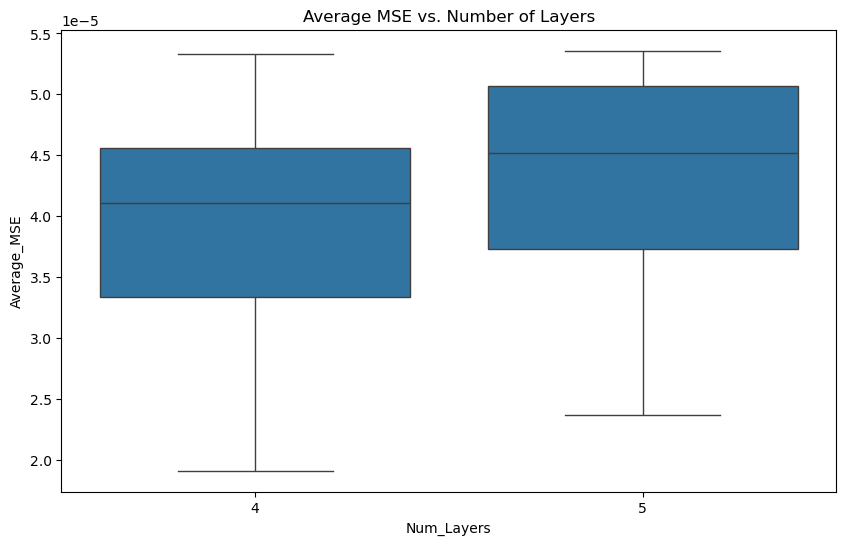

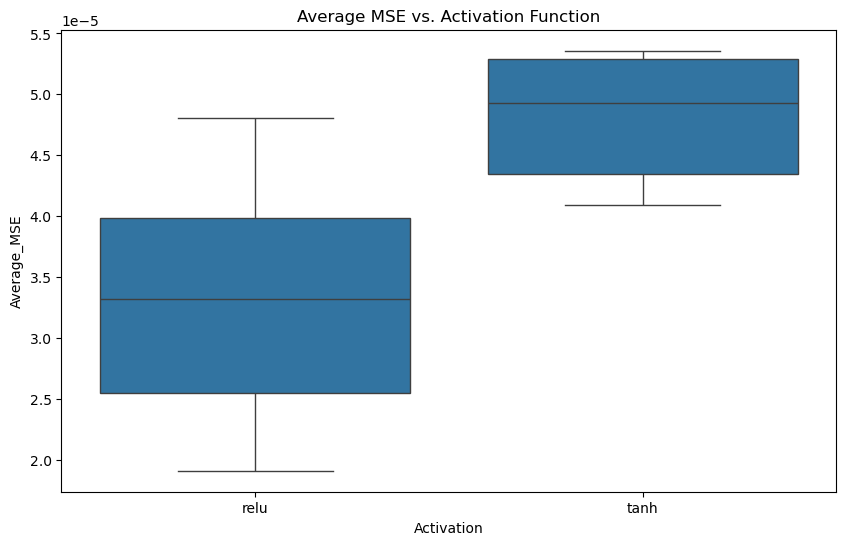

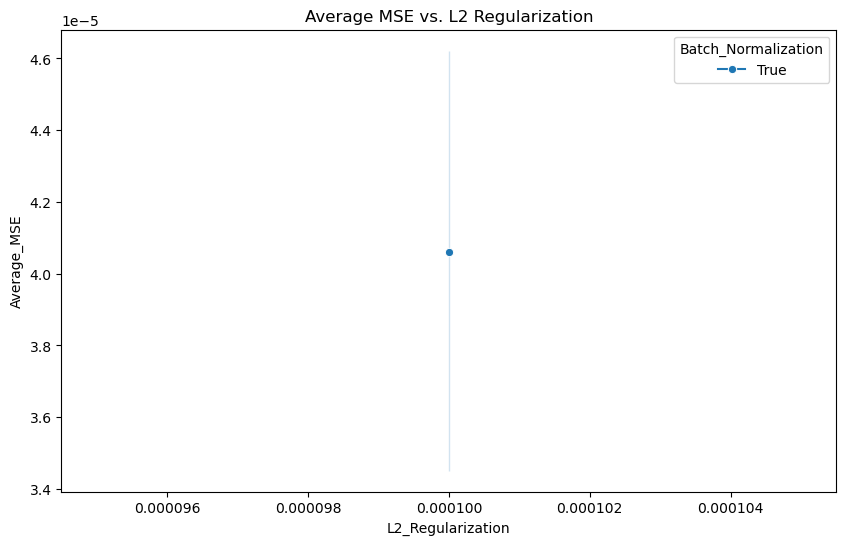

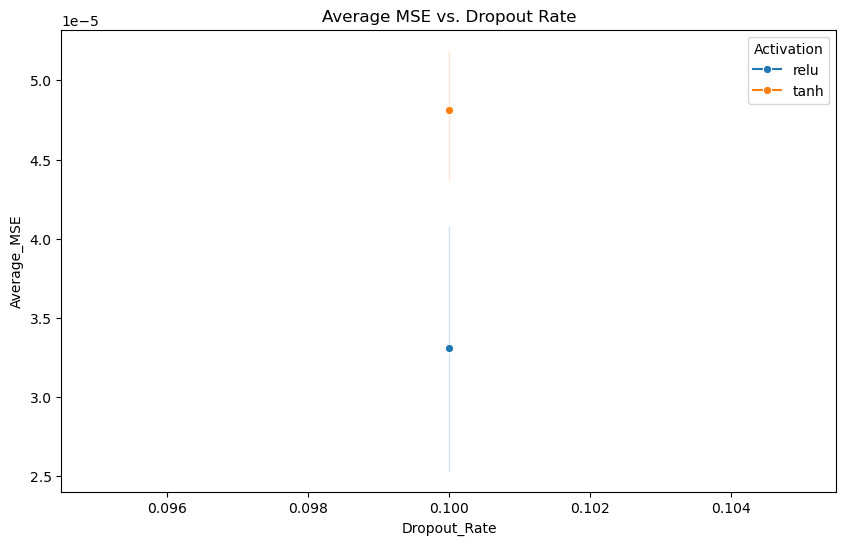

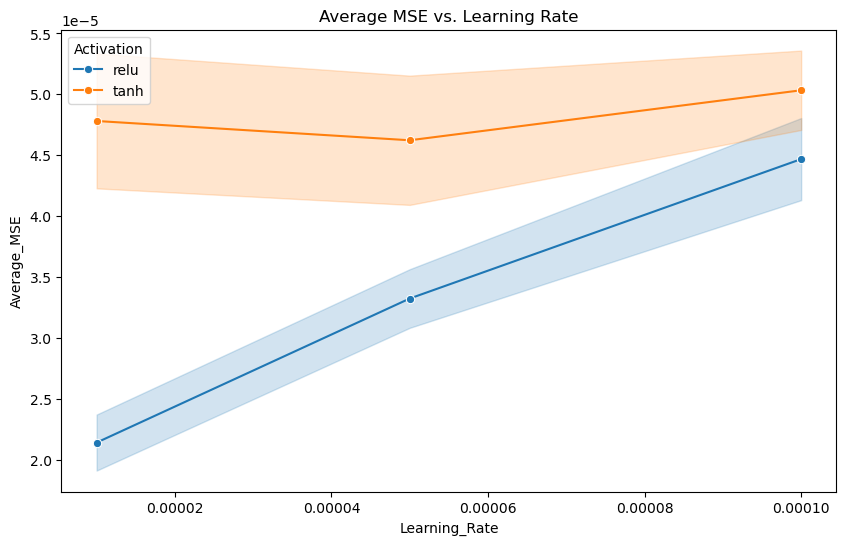

In [20]:
import seaborn as sns

# Plot Average MSE vs. Number of Layers
results_df['Num_Layers'] = results_df['Layers'].apply(len)
plt.figure(figsize=(10,6))
sns.boxplot(x='Num_Layers', y='Average_MSE', data=results_df)
plt.title('Average MSE vs. Number of Layers')
plt.show()

# Plot Average MSE vs. Activation Function
plt.figure(figsize=(10,6))
sns.boxplot(x='Activation', y='Average_MSE', data=results_df)
plt.title('Average MSE vs. Activation Function')
plt.show()

# Plot Average MSE vs. L2 Regularization
plt.figure(figsize=(10,6))
sns.lineplot(x='L2_Regularization', y='Average_MSE', hue='Batch_Normalization', data=results_df, marker='o')
plt.title('Average MSE vs. L2 Regularization')
plt.show()

# Plot Average MSE vs. Dropout Rate
plt.figure(figsize=(10,6))
sns.lineplot(x='Dropout_Rate', y='Average_MSE', hue='Activation', data=results_df, marker='o')
plt.title('Average MSE vs. Dropout Rate')
plt.show()

# Plot Average MSE vs. Learning Rate
plt.figure(figsize=(10,6))
sns.lineplot(x='Learning_Rate', y='Average_MSE', hue='Activation', data=results_df, marker='o')
plt.title('Average MSE vs. Learning Rate')
plt.show()

## Selecting the Best Configuration
Based on the results, you can select the configuration with the lowest average MSE or any other metric that suits your needs.

In [22]:
# Find the best configuration based on Average MSE
best_config = results_df.loc[results_df['Average_MSE'].idxmin()]
print("\n--- Best Configuration ---")
print(best_config)


--- Best Configuration ---
Layers                 [256, 128, 64, 32]
Activation                           relu
L2_Regularization                  0.0001
Dropout_Rate                          0.1
Batch_Normalization                  True
Learning_Rate                     0.00001
Average_Loss                     0.000069
Average_MAE                      0.003125
Average_MSE                      0.000019
Num_Layers                              4
Name: 2, dtype: object


## Final Training on Entire Dataset
After identifying the best configuration, you can train a final model on the entire training dataset and evaluate it on the test set.

In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import joblib
# Save the scaler
joblib.dump(scaler, 'scaler_log.pkl')

print("Min y_train:", np.min(y_train))
print("Max y_train:", np.max(y_train))

Min y_train: 0.00114867877595944
Max y_train: 1.5996497475974216


In [26]:
# Extract best configuration parameters
best_layers = best_config['Layers']
best_activation = best_config['Activation']
best_l2 = best_config['L2_Regularization']
best_dropout = best_config['Dropout_Rate']
best_batch_norm = best_config['Batch_Normalization']
best_learning = best_config['Learning_Rate']


# Build the best model
best_model = build_model(input_dim=X_train.shape[1],
                         nr_neurons=best_layers,
                         reg_param=best_l2,
                         activation=best_activation,
                         use_batch_norm=best_batch_norm,
                         dropout_rate=best_dropout,
                         learning_rate=best_learning)

# Train the model on the entire dataset
history = best_model.fit(X_train, y_train,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_split=0.2,
                         callbacks=[early_stop],
                         verbose=1)

# Evaluate the final model
test_loss, test_mae, test_mse = best_model.evaluate(X_test, y_test, verbose=1)
print(f"\nFinal Model Test Loss (MSE): {test_loss:.4f}")
print(f"Final Model Test MAE: {test_mae:.4f}")
print(f"Final Model Test MSE: {test_mse:.4f}")

# Save the final model
best_model.save("best_NN_lognormal.h5")
print("Best model saved as 'best_NN_lognormal.h5'")


Epoch 1/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.5013 - mae: 1.2936 - mse: 2.4706 - val_loss: 1.1794 - val_mae: 1.0041 - val_mse: 1.1486
Epoch 2/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5617 - mae: 1.0595 - mse: 1.5309 - val_loss: 0.9956 - val_mae: 0.9450 - val_mse: 0.9649
Epoch 3/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3165 - mae: 0.9891 - mse: 1.2857 - val_loss: 0.8811 - val_mae: 0.8976 - val_mse: 0.8503
Epoch 4/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1596 - mae: 0.9354 - mse: 1.1289 - val_loss: 0.7931 - val_mae: 0.8553 - val_mse: 0.7624
Epoch 5/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0317 - mae: 0.8856 - mse: 1.0010 - val_loss: 0.7061 - val_mae: 0.8076 - val_mse: 0.6754
Epoch 6/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9278 - mae: 0.8389 - mse: 0.8971 - val_loss: 0.6327 - val_mae: 0.7639 - val_mse: 0.6020
Epoch 7/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8294 - mae: 0.7898 - mse: 0.798


Final Model Test Loss (MSE): 0.0001
Final Model Test MAE: 0.0033
Final Model Test MSE: 0.0000
Best model saved as 'best_NN_lognormal.h5'


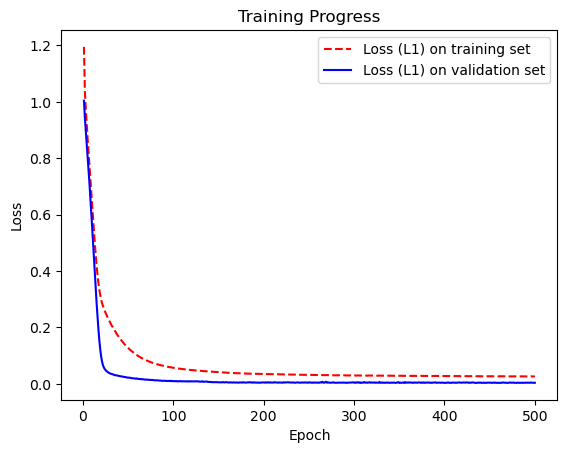

In [27]:
# Plot the training process
training_loss = history.history["mae"]
val_loss = history.history["val_mae"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, val_loss, "b-")
plt.legend(["Loss (L1) on training set", "Loss (L1) on validation set"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Progress")
plt.savefig('history_lognormal.eps', format='eps')
plt.show()

In [28]:
# Generate 5 random indices
indices = np.random.randint(0, len(X_test), size=5)

# Make predictions for the selected indices
print("Prediction")
predictions = np.round(best_model.predict(X_test[indices]), 5)  # Adjust scaling if needed
print(predictions)

# True values for the same indices
print("True Values")
true_values = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]
print(true_values)

Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0.50381]
 [0.41133]
 [1.20355]
 [1.13174]
 [1.39513]]
True Values
286747    0.520008
406218    0.416252
595726    1.201262
366023    1.136058
235357    1.394095
Name: Price, dtype: float64


In [29]:
# Define custom objects dictionary
custom_objects = {"mse": tf.keras.losses.MeanSquaredError()}

# Load the saved model
best_model = tf.keras.models.load_model("best_NN_lognormal.h5", custom_objects=custom_objects)

# Define the feature names (match the original dataset used to fit the scaler)
feature_names = ["r", "lambda", "D", "N", "T"]  # Update with actual names

We evaluate the neural network

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1s 222us/step
Average Error: 0.0033
Average Relative Error: 0.0058
Large errors (greater than 0.05):
[]


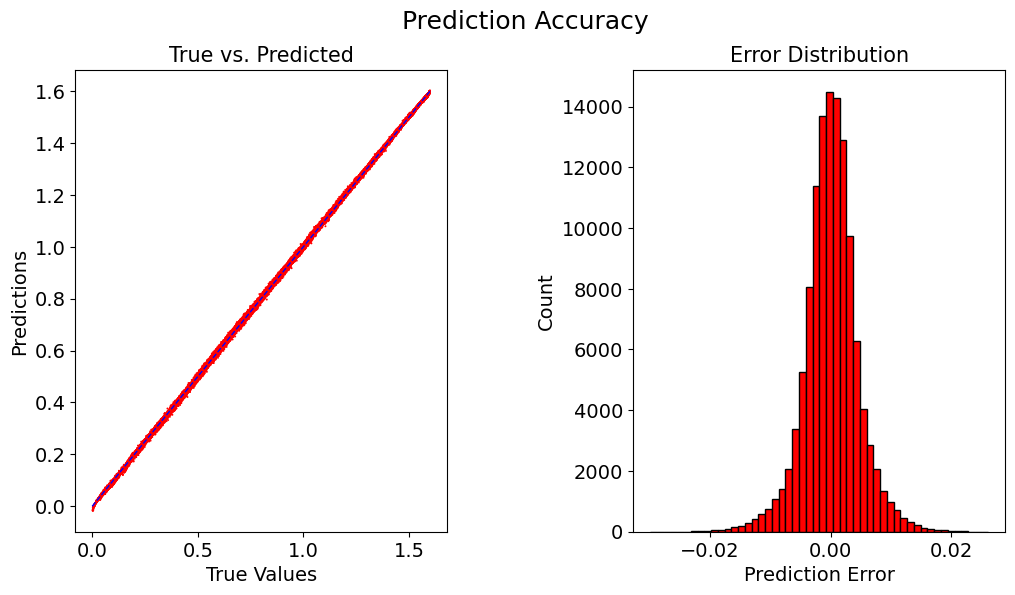

In [30]:
# Predictions
test_predictions = best_model.predict(X_test).flatten()

y_test = np.array(y_test).flatten()

# Calculate the MAE
MAE_error = np.abs(test_predictions - y_test)

# Calculate the relative error
relative_error = np.abs(test_predictions - y_test) / np.abs(y_test)

# Print average prediction error
print(f'Average Error: {np.mean(MAE_error):.4f}')

# Print average relative error
print(f'Average Relative Error: {np.mean(relative_error):.4f}')

# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5)

# Scatter plot: True values vs. Predictions
axs[0].plot([0, max(test_predictions)], [0, max(test_predictions)], color="blue", linestyle="--", linewidth=1)
axs[0].scatter(y_test, test_predictions, c='red', s=2, edgecolors='None')
axs[0].set_xlabel('True Values', fontsize=14)
axs[0].set_ylabel('Predictions', fontsize=14)
axs[0].set_title('True vs. Predicted', fontsize=15)
# Customize tick label size
axs[0].tick_params(axis='both', labelsize=14)

# Histogram: Prediction Error
error = (test_predictions - y_test).flatten()
# Get errors greater than 0.05
large_errors = error[error > 0.1]

# Print large errors
print("Large errors (greater than 0.05):")
print(large_errors)

filtered_error = error[error <= 0.1]

axs[1].hist(filtered_error, bins=50, color='red', edgecolor='black')
axs[1].set_xlabel("Prediction Error", fontsize=14)
axs[1].set_ylabel("Count", fontsize=14)
axs[1].set_title('Error Distribution', fontsize=15)
# Customize tick label size
axs[1].tick_params(axis='both', labelsize=14)

# Save the figure
fig.suptitle('Prediction Accuracy', fontsize=18)
plt.savefig('accuracy_lognormal.eps', format='eps', bbox_inches='tight')
plt.show()

We also consider relative errors (Division by spot values)

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1s 220us/step


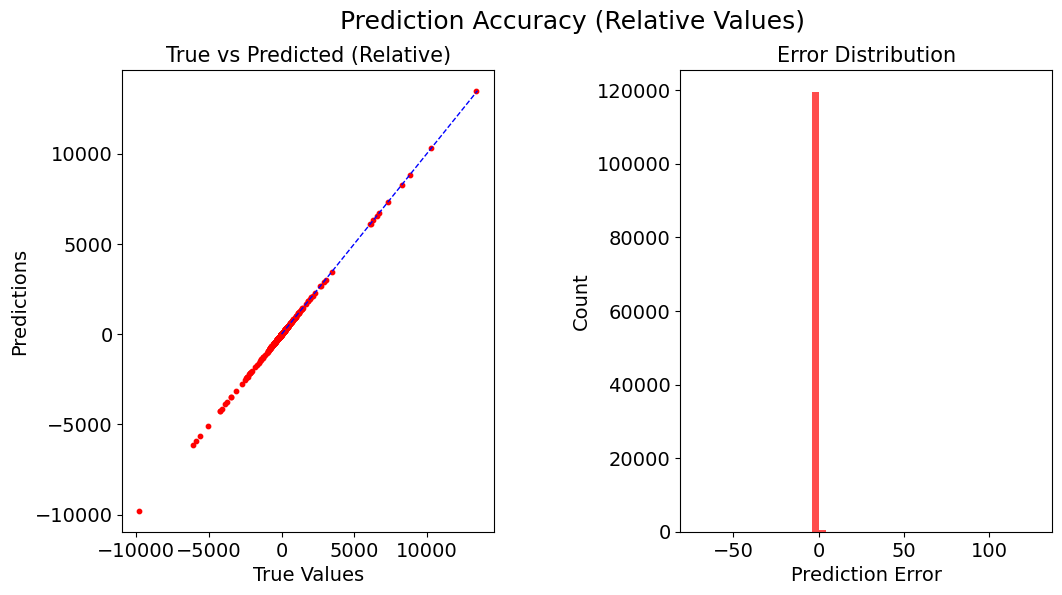

Model Evaluation 

Relative Mean Absolute Error: 0.0214376370602312


In [31]:
# Ensure that predictions and true values are scaled properly using the first column of X_test
first_column = X_test[:, 0]  # Select the first column from X_test
scaled_first_column = np.tile(first_column, 2)  # Repeat the first column to match the size

# Predict the test set
test_predictions = best_model.predict(X_test).flatten()
y_test_values = np.array(y_test).flatten()

# Scale both predictions and true values by the first column of X_test
test_predictions_relative = test_predictions / scaled_first_column[:len(test_predictions)]
y_test_relative = y_test_values / scaled_first_column[:len(y_test_values)]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5)

# Plot true vs predicted values along a line
axs[0].plot([0, max(test_predictions_relative)], [0, max(test_predictions_relative)], color="blue", linestyle="--", linewidth=1)
axs[0].scatter(y_test_relative, test_predictions_relative, c='red', s=10, edgecolors='face')
axs[0].set_xlabel('True Values', fontsize=14)
axs[0].set_ylabel('Predictions', fontsize=14)
axs[0].set_title('True vs Predicted (Relative)', fontsize=15)
# Customize tick label size
axs[0].tick_params(axis='both', labelsize=14)

# Plot histogram of errors
error = test_predictions_relative - y_test_relative
axs[1].hist(error, bins=50, color='red', alpha=0.7)
axs[1].set_xlabel("Prediction Error", fontsize=14)
axs[1].set_ylabel("Count", fontsize=14)
axs[1].set_title('Error Distribution', fontsize=15)
# Customize tick label size
axs[1].tick_params(axis='both', labelsize=14)

# Set the main title for the figure
fig.suptitle('Prediction Accuracy (Relative Values)', fontsize=18)

# Save the plot as EPS
plt.savefig('accuracy_relative_lognormal.eps', format='eps', bbox_inches='tight')
plt.show()

# Evaluate the model with relative error
relative_mae = np.mean(np.abs(test_predictions_relative - y_test_relative))
print(f"Model Evaluation \n\nRelative Mean Absolute Error: {relative_mae}")